In [41]:
import numpy as np
import matplotlib.pyplot as plt
import RF_Track
from scipy.optimize import minimize
import re

## Beam and Lattice parameters

In [42]:
# Beam parameters
mass = RF_Track.electronmass    # particle mass in MeV/c^2
population = 300 * RF_Track.pC               # number of particles per bunch
Q = -1                          # particle charge in e units
P_ref = 198                     # reference momentum in MeV/c

freq = 2.997e9                  # Hz


# Another way 

# energy_MeV = 200
# P_ref = np.sqrt((energy_MeV + 0.511)**2 - 0.511**2)
# print(f"Calculated momentum: {P_calc:.2f} MeV/c")
# population = 50 * RF_Track.pC # number of real particles per bunch

In [43]:
### Lattice parameters
nr_quad = 11
Lquad = 0.226  # magnetic length of the quadrupole in m
nominal_K = 0.7752883624676146 #3.35  # 1/m

# Integral Transfer Function
def get_ITF(I):
    return 1.29404711e-2  - 2.59458259e-07*I # T/A

def get_grad(I, Lquad):
    G_0 = I * get_ITF(I) / Lquad    # T/m
    return G_0

def get_Quad_K(G_0, P_ref):
    K = 299.8 *G_0 / P_ref  # 1/m^2
    return K

def get_Quad_K_from_I(I, Lquad, P_ref):
    G_0 = get_grad(I, Lquad)
    K = get_Quad_K(G_0, P_ref)
    return K

In [44]:
# ENTIRE CLEAR LINE LATTICE CONSTRUCTION, FROM THE SURVEY FILE

# Source (November 2024)
# https://gitlab.cern.ch/acc-models/acc-models-clear/-/blob/master/survey/clear.survey0_filtered.tfs?ref_type=heads

# Load survey file
with open("../Interfaces/CLEAR/CLEAR_Beamline_Survey.txt", encoding="utf-8", errors="ignore") as f:
    lines = f.readlines()

# Loop through the survey line-by-line and construct a dict of all relevant elements
element_descriptions = {}
previous_name = None
quad_index = 0
corr_index = 0
for line in lines:
    # Skip preamble
    if line[0:2] != ' "':
        continue

    # Find relevant parts of text
    text = re.findall(r'"([A-Za-z0-9.$_]+)"', line)
    numbers = re.findall(r'\d+\.\d+', line)

    name = text[0]

    # Skip unused screens
    if name == 'CA.BTV0800':
        continue

    # Specify element type
    element_type = None
    if 'QFD' in name or 'QDD' in name:
        element_type = 'Quadrupole'
    elif 'BTV' in name:
        element_type = 'Screen'
    elif 'DHG' in name or 'DHJ' in name:
        element_type = 'Corrector'
    elif 'BPC' in name or 'BPM' in name:
        element_type = 'BPM'
    elif text[1] == 'MARKER':
        element_type = 'Marker'

    # If the element type is none of the above, skip this element
    if element_type is None:
        continue

    # Set length and position
    s_end = float(numbers[0])
    L = float(numbers[1])
    s_start = s_end - L

    # Round values to remove float errors
    L = round(L, 4)
    s_start = round(s_start, 4)
    s_end = round(s_end, 4)

    # Add drift from previous element
    if previous_name is not None:
        L_drift = round(s_start - element_descriptions[previous_name]['s_end'], 4)
        if L_drift != 0:
            element_descriptions[previous_name + ' Drift'] = {
                'element_type': 'Drift',
                'L': L_drift,
                's_start': element_descriptions[previous_name]['s_end'], 
                's_end': s_start,
                'quad_index': None,
                'corr_index': None,
            }

    # Add current element
    element_descriptions[name] = {
        'element_type': element_type,
        'L': L,
        's_start': s_start, 
        's_end': s_end,
        'quad_index': quad_index if element_type == 'Quadrupole' else None,
        'corr_index': corr_index if element_type == 'Corrector' else None,
    }

    if element_type == 'Quadrupole':
        quad_index += 1

    if element_type == 'Corrector':
        corr_index += 1
    
    previous_name = name

# Return a lattice object from start to end, using a current vector with the currents of each quad in order
def get_lattice(start, end, P_ref, quad_currents, include_end = True):
    start_index = list(element_descriptions.keys()).index(start)
    end_index = list(element_descriptions.keys()).index(end)
    if include_end: end_index += 1

    
    lattice = RF_Track.Lattice()
    names = list(element_descriptions.keys())
    elements = list(element_descriptions.values())
    for name, element_description in zip(names[start_index:end_index], elements[start_index:end_index]):
        element_type = element_description['element_type']
        L = element_description['L']
        s_start = element_description['s_start']
        s_end = element_description['s_end']
        quad_index = element_description['quad_index']

        if element_type == 'Drift':
            element = RF_Track.Drift(L)
        elif element_type == 'Quadrupole':
            if 'QFD' in name:
                K = get_Quad_K_from_I(quad_currents[quad_index], L, P_ref)
            elif 'QDD' in name:
                K = -get_Quad_K_from_I(quad_currents[quad_index], L, P_ref)
            element = RF_Track.Quadrupole(L, P_ref/Q, K)
        elif element_type == 'Corrector':
            element = RF_Track.Corrector(L)
        elif element_type == 'BPM':
            element = RF_Track.Bpm(L)
        elif element_type == 'Screen':
            element = RF_Track.Screen()
        elif element_type == 'Marker':
            element = RF_Track.Screen()

        lattice.append(element)

        
    return lattice

start = 'CA.ACS0270S_MECH' # 'CA.QFD0350'
end = 'CA.STLINE$END'
lattice = get_lattice(start, end, P_ref, np.array(11*[0]))


print(lattice.get_length())
print(element_descriptions[end]['s_end'] - element_descriptions[start]['s_start'])

19.318000000000005
19.317999999999998


## ATTENTION: LATTICE CONSTRUCTION AHEAD
## (Build your own lattice)

In [45]:
### ATTENTION ###
# LATTICE CONSTRUCTION AHEAD
quad_currents = np.array([
    0,        #QFD350
    0,        #QDD355
    0,        #QFD360

    20,        #QFD510
    40.96551724137931,        #QDD515
    20,        #QFD520

    0,        #QFD760
    0,        #QDD765
    0,        #QFD770

    0,        #QDD870
    0         #QFD880
])    # A

# Here the lattice is constructed from the desired start to the desired end
L = get_lattice('CA.QFD0350', 'CA.BTV0910', P_ref, quad_currents, include_end=False)

length = L.get_length()
print(length)
print(element_descriptions['CA.BTV0910']['s_end'] - element_descriptions['CA.QFD0350']['s_start'])

17.211
17.211


In [46]:
# Extra drift for In-Air Test Stand

Drift1 = RF_Track.Drift(1.0)
L.append(Drift1)

L.get_length()

18.211

## TWISS PARAMETERS: Insertion, tracking and check

In [47]:
# Twiss parameters
# They have to be inserted here
# They are the ones at the starting point of your constructed lattice

Twiss = RF_Track.Bunch6d_twiss()

Twiss.beta_x = 15.6        # m
Twiss.beta_y = 24 # 2.73        # m
Twiss.alpha_x = -0.49
Twiss.alpha_y = -3.65 # 0.339
Twiss.emitt_x = 7.04     # mm.mrad normalised emittance
Twiss.emitt_y = 3.39 # 0.727      # mm.mrad
# Twiss.sigma_t = 10 * RF_Track.ps       # mm/c   or 37 * RF_Track.ps
# Twiss.sigma_pt = 10     # permille
Twiss.mean_xp = 0.0
Twiss.mean_yp = 0.0

In [48]:
# Setup
N = 10000
P0 = RF_Track.Bunch6d(mass, population, Q, np.array([0,0,0,0,0,P_ref]).T)   # reference particle
B0 = RF_Track.Bunch6d(mass, population, Q, P_ref, Twiss, N)             # reference bunch

# n_bunches = 1
# bunch_spacing = 0.0 * RF_Track.ns # mm/c

# B0 = RF_Track.Beam(n_bunches, Bunch, bunch_spacing)

(10000, 6)


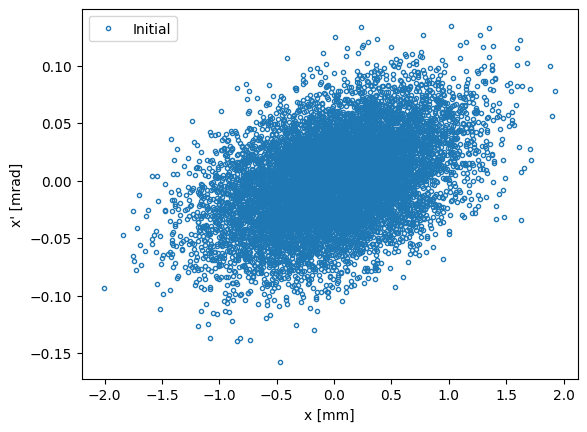

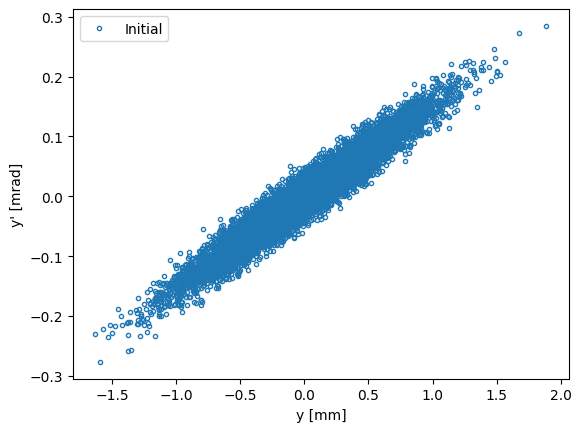

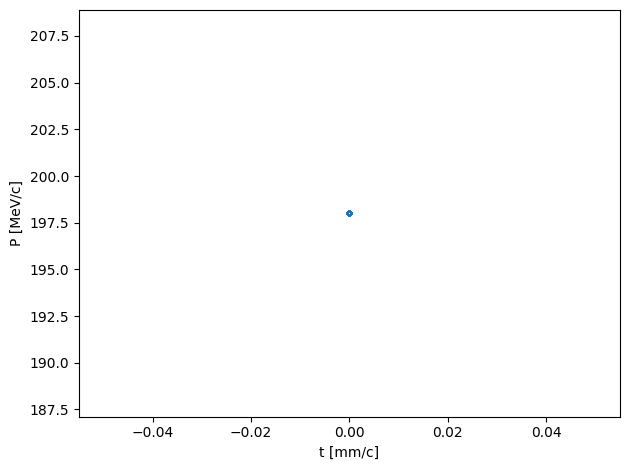

In [49]:
# Initial phase space distribution

M0 = B0.get_phase_space ('%x %xp %y %yp %dt %P')
print(M0.shape)
plt.figure()
plt.plot(M0[:,0], M0[:,1], '.', label='Initial', mfc='none')
plt.xlabel('x [mm]')
plt.ylabel("x' [mrad]")
plt.legend()

plt.figure()
plt.plot(M0[:,2], M0[:,3], '.', label='Initial', mfc='none')
plt.xlabel('y [mm]')
plt.ylabel("y' [mrad]")
plt.legend()

plt.figure()
plt.plot(M0[:,4], M0[:,5], '.', label='Initial', mfc='none')
plt.xlabel('t [mm/c]')
plt.ylabel('P [MeV/c]')
plt.tight_layout()

In [50]:
def get_Twiss(Bunch):
    I0 = Bunch.get_info()
    pos0 = I0.S
    beta_x = I0.beta_x
    beta_y = I0.beta_y
    alpha_x = I0.alpha_x
    alpha_y = I0.alpha_y
    emitt_x = I0.emitt_x
    emitt_y = I0.emitt_y
    sigma_t = I0.sigma_t
    sigma_pt = I0.sigma_pt
    sigma_x = I0.sigma_x
    sigma_y = I0.sigma_y
    mean_x = I0.mean_x
    mean_y = I0.mean_y
    mean_xp = I0.mean_xp
    mean_yp = I0.mean_yp
    return pos0, beta_x, beta_y, alpha_x, alpha_y, emitt_x, emitt_y, sigma_t, sigma_pt, sigma_x, sigma_y, mean_x, mean_y, mean_xp, mean_yp

def print_Twiss(Bunch):
    pos0, beta_x, beta_y, alpha_x, alpha_y, emitt_x, emitt_y, sigma_t, sigma_pt, sigma_x, sigma_y, mean_x, mean_y, mean_xp, mean_yp = get_Twiss(Bunch)
    print(f"Position: {pos0:.2f} m")
    print(f"beta_x: {beta_x:.2f} m")
    print(f"beta_y: {beta_y:.2f} m")
    print(f"alpha_x: {alpha_x:.2f}")
    print(f"alpha_y: {alpha_y:.2f}")
    print(f"emittance_x: {emitt_x:.2f} mm.mrad")
    print(f"emittance_y: {emitt_y:.2f} mm.mrad")
    print(f"sigma_t: {sigma_t:.2f} mm/c")
    print(f"sigma_pt: {sigma_pt:.2f} permille")
    print(f"sigma_x: {sigma_x:.2f} mm")
    print(f"sigma_y: {sigma_y:.2f} mm")
    print(f"mean_x: {mean_x:.2f} mm")
    print(f"mean_y: {mean_y:.2f} mm")
    print(f"mean_xp: {mean_xp:.2f} mrad")
    print(f"mean_yp: {mean_yp:.2f} mrad")


In [51]:
### Initial Twiss params

get_Twiss(B0)
print_Twiss(B0)

Position: 0.00 m
beta_x: 15.47 m
beta_y: 23.99 m
alpha_x: -0.48
alpha_y: -3.65
emittance_x: 7.04 mm.mrad
emittance_y: 3.39 mm.mrad
sigma_t: 0.00 mm/c
sigma_pt: 0.00 permille
sigma_x: 0.53 mm
sigma_y: 0.46 mm
mean_x: 0.00 mm
mean_y: -0.00 mm
mean_xp: -0.00 mrad
mean_yp: 0.00 mrad


In [52]:
# Tracking

P1 = L.track(P0)        # Track the reference particle
B1 = L.track(B0)        # Track the reference bunch

In [53]:
### Final Twiss params
get_Twiss(B1)
print_Twiss(B1)

Position: 18.21 m
beta_x: 11.83 m
beta_y: 2.66 m
alpha_x: -0.26
alpha_y: -0.17
emittance_x: 7.04 mm.mrad
emittance_y: 3.39 mm.mrad
sigma_t: 0.00 mm/c
sigma_pt: 0.00 permille
sigma_x: 0.46 mm
sigma_y: 0.15 mm
mean_x: -0.00 mm
mean_y: 0.00 mm
mean_xp: -0.00 mrad
mean_yp: 0.00 mrad


## Transport Table getting, followed by phase space extraction

In [54]:
T = L.get_transport_table('%S %sigma_x %sigma_y %sigma_t %sigma_E %mean_E %emitt_x %emitt_y %beta_x %beta_y')
M1 = B1.get_phase_space('%x %xp %y %yp %dt %P')
print(M1)
# print(T)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.98000000e+02]
 [-9.39178511e-02 -6.89059347e-02 -1.31138559e-01  6.05971016e-02
   1.84445817e-04  1.98000000e+02]
 [ 1.30883408e-01  1.34703991e-02 -1.31049504e-01 -2.64682818e-02
   1.09263310e-05  1.98000000e+02]
 ...
 [-2.91137457e-01 -1.29925051e-02 -1.07395527e-01  8.62734842e-02
   2.24697495e-04  1.98000000e+02]
 [-6.64264054e-01 -5.57150562e-02  1.41928460e-02  6.81140864e-02
   1.43083966e-04  1.98000000e+02]
 [-5.52809738e-01 -4.40496936e-02 -6.62176825e-02 -5.10830964e-03
   1.76135618e-05  1.98000000e+02]]


In [55]:
M0 = B0.get_phase_space('%x %xp %y %yp %dt %P')
print(M0)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.98000000e+02]
 [ 8.38190731e-01  3.22190712e-03 -5.16425714e-01 -9.67786687e-02
   0.00000000e+00  1.98000000e+02]
 [-9.60558244e-02  8.88109281e-03  1.77347369e-01  1.11365675e-02
   0.00000000e+00  1.98000000e+02]
 ...
 [-6.71213182e-03 -2.25038236e-02 -7.14939520e-01 -1.24674219e-01
   0.00000000e+00  1.98000000e+02]
 [ 3.23233652e-01 -4.71225306e-02 -5.39109293e-01 -8.20676626e-02
   0.00000000e+00  1.98000000e+02]
 [ 2.38910082e-01 -3.95913147e-02  2.37483906e-02 -4.61665311e-03
   0.00000000e+00  1.98000000e+02]]


Text(0, 0.5, 'K [MeV]')

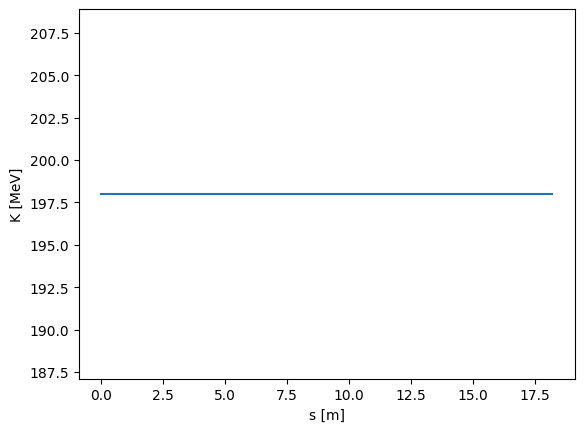

In [56]:
# Momentum over distance

T = L.get_transport_table('%S %mean_P')

plt.plot (T[:, 0], T[:, 1])
plt.xlabel ('s [m]')
plt.ylabel ('K [MeV]')

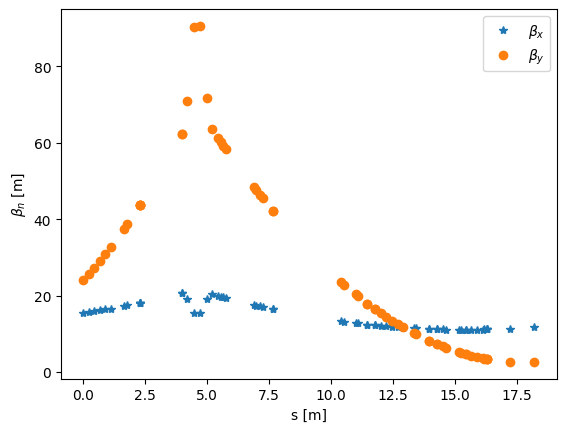

In [57]:
# Beta evolution over the line

T = L.get_transport_table('%S %beta_x %beta_y')  
plt.plot(T[:,0], T[:,1], '*', linewidth=2,)
plt.plot(T[:,0], T[:,2], 'o', linewidth=2,)
plt.legend([r'$\beta_x$', r'$\beta_y$'])
plt.xlabel('s [m]')
plt.ylabel(r'$\beta_n$ [m]')
plt.show()

Screens in lattice:
CA.BTV0390 -> BTV0390 at 20.5564
CA.BTV0620 -> BTV0620 at 25.9344
CA.BTV0730 -> BTV0730 at 29.7544
CA.BTV0810 -> BTV0810 at 32.5494
CA.BTV0910 -> BTV0910 at 35.4944


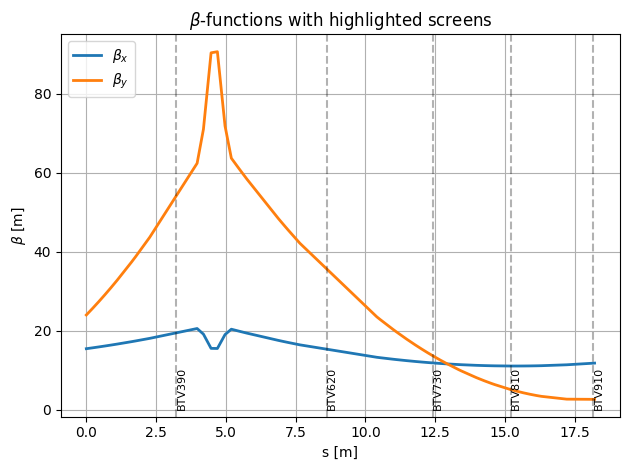

In [58]:
# TO BE USED WITH FULL LATTICE

# Plotting beta functions
plt.plot(T[:, 0], T[:, 1], label=r'$\beta_x$', linewidth=2)
plt.plot(T[:, 0], T[:, 2], label=r'$\beta_y$', linewidth=2)

# Optional: set specific screens to highlight (or set to [] to include all)
highlight_filter = ['BTV390', 'BTV620', 'BTV730', 'BTV810', 'BTV910']  # <- short names
highlight_positions = []
highlight_names = []

# Reconstruct lattice positions
s = 0.0
names = list(element_descriptions.keys())
start_index = names.index(start)
end_index = names.index(end) + 1
names_in_lattice = names[start_index:end_index]

for name in names_in_lattice:
    elem = element_descriptions[name]
    L = elem['L']
    elem_type = elem['element_type']

    if elem_type == 'Screen':
        short_name = name.split('.')[-1].replace('BTV0', 'BTV').replace('BTV', 'BTV')  # unify format
        if not highlight_filter or short_name in highlight_filter:
            # Compute center of element (if L > 0), or use current s (if L == 0)
            center = s + L / 2 if L > 0 else s
            highlight_positions.append(center)
            highlight_names.append(short_name)

    s += L


print("Screens in lattice:")
for name in names_in_lattice:
    elem = element_descriptions[name]
    if elem['element_type'] == 'Screen':
        print(name, "->", name.split('.')[-1], "at", elem['s_start'])

# Plot the screen markers
for name, pos in zip(highlight_names, highlight_positions):
    plt.axvline(x=pos, color='k', linestyle='--', alpha=0.3)
    plt.text(pos, 0, name, rotation=90, verticalalignment='bottom', fontsize=8)

plt.legend()
plt.xlabel('s [m]')
plt.ylabel(r'$\beta$ [m]')
plt.title(r'$\beta$-functions with highlighted screens')
plt.tight_layout()
plt.grid(True)
plt.show()


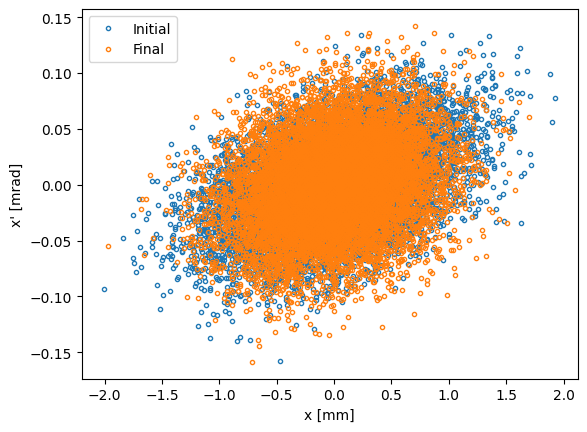

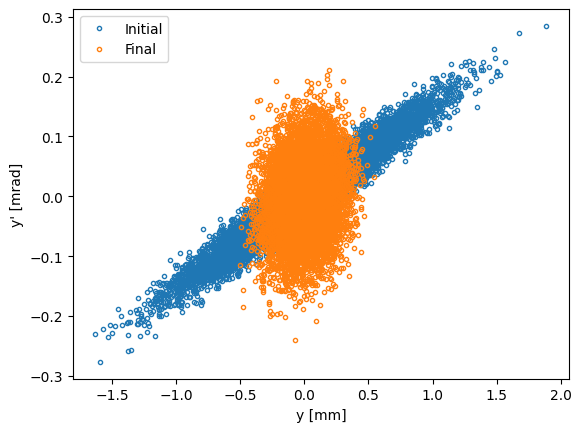

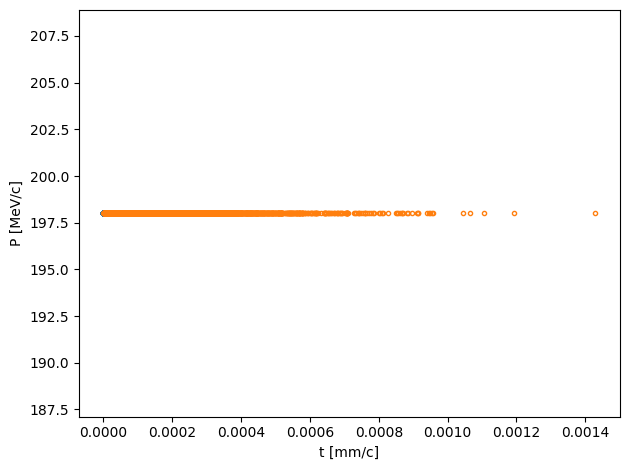

In [59]:
# Phase Space: Initial and Final

M0 = B0.get_phase_space ('%x %xp %y %yp %dt %P')
M1 = B1.get_phase_space ('%x %xp %y %yp %dt %P')

plt.figure()
plt.plot(M0[:,0], M0[:,1], '.', label='Initial', mfc='none')
plt.plot(M1[:,0], M1[:,1], '.', label='Final', mfc='none')
plt.xlabel('x [mm]')
plt.ylabel("x' [mrad]")
plt.legend()

plt.figure()
plt.plot(M0[:,2], M0[:,3], '.', label='Initial', mfc='none')
plt.plot(M1[:,2], M1[:,3], '.', label='Final', mfc='none')
plt.xlabel('y [mm]')
plt.ylabel("y' [mrad]")
plt.legend()

plt.figure()
plt.plot(M0[:,4], M0[:,5], '.', label='Final', mfc='none')
plt.plot(M1[:,4], M1[:,5], '.', label='Final', mfc='none')
plt.xlabel('t [mm/c]')
plt.ylabel('P [MeV/c]')
plt.tight_layout()

# T = L.get_transport_table('%S %sigma_x %sigma_y %sigma_t %sigma_E %mean_E %emitt_x %emitt_y')

### R Matrix and Phase Advance Tryouts

In [60]:
M0 = B0.get_phase_space('%x %xp %y %yp %dt %pt')
M1 = B1.get_phase_space('%x %xp %y %yp %dt %pt')

x0  = M0[:,0]
xp0 = M0[:,1]
y0  = M0[:,2]
yp0 = M0[:,3]
t0  = M0[:,4]
d0  = M0[:,5]

x1  = M1[:,0]
xp1 = M1[:,1]
y1  = M1[:,2]
yp1 = M1[:,3]
t1  = M1[:,4]
d1  = M1[:,5]

I = np.ones(x0.size)
I1 = np.array([x1,xp1,y1,yp1,t1,d1]).T
I0 = [I, # K - 0th order
      x0,xp0,y0,yp0,t0,d0, # R - 1st order
      x0**2,xp0**2,y0**2,yp0**2,t0**2*d0**2, # T 2nd-order
      x0*xp0,x0*y0,x0*yp0,x0*t0,x0*d0, # T
      xp0*y0,xp0*yp0,xp0*t0,xp0*d0, # T
      y0*yp0,y0*t0,y0*d0, # T
      yp0*t0,yp0*d0, # T
      t0*d0, # T
      d0*d0*d0,d0*d0*t0,d0*d0*x0,d0*d0*xp0,d0*d0*y0, # U - 3rd order
      d0*d0*yp0,d0*t0*t0,d0*t0*x0,d0*t0*xp0,d0*t0*y0, # U
      d0*t0*yp0,d0*x0*x0,d0*x0*xp0,d0*x0*y0,d0*x0*yp0, # U
      d0*xp0*xp0,d0*xp0*y0,d0*xp0*yp0,d0*y0*y0, # U
      d0*y0*yp0,d0*yp0*yp0,t0*t0*t0,t0*t0*x0,t0*t0*xp0, # U
      t0*t0*y0,t0*t0*yp0,t0*x0*x0,t0*x0*xp0,t0*x0*y0, # U
      t0*x0*yp0,t0*xp0*xp0,t0*xp0*y0,t0*xp0*yp0, # U
      t0*y0*y0,t0*y0*yp0,t0*yp0*yp0,x0*x0*x0,x0*x0*xp0, # U
      x0*x0*y0,x0*x0*yp0,x0*xp0*xp0,x0*xp0*y0, # U
      x0*xp0*yp0,x0*y0*y0,x0*y0*yp0,x0*yp0*yp0, # U
      xp0*xp0*xp0,xp0*xp0*y0,xp0*xp0*yp0,xp0*y0*y0, # U
      xp0*y0*yp0,xp0*yp0*yp0,y0*y0*y0,y0*y0*yp0, # U
      y0*yp0*yp0,yp0*yp0*yp0] # U
I0 = np.array(I0).T

M = np.linalg.lstsq(I0, I1, rcond=None)[0].T
K = M[:,0]
R = M[:,1:7]
T = M[:,7:28]
U = M[:,28:]

K.shape, R.shape, T.shape

# Tracking
MT = np.concatenate((K.reshape(6,1), R, T, U), axis=1)
I1_predicted = (MT @ I0.T).T

det_R =np.linalg.det(R)
print('det_R = ', det_R)


det_R =  0.0


In [61]:
beta_xi = B0.get_info().beta_x
beta_xf = B1.get_info().beta_x
alpha_xi = B0.get_info().alpha_x
alpha_xf = B1.get_info().alpha_x

# from R12 = sqrt(beta_xf*beta_xi) * sin_phix
sin_phix = R[0,1] / np.sqrt(beta_xf*beta_xi)

# from R11
cos_phix = R[0,0] * np.sqrt(beta_xi/beta_xf) - alpha_xi*sin_phix

# Ways are equivalent, it's just to double check
print(f'phix = asin(sin_phix) = {np.rad2deg(np.asin(sin_phix))} deg')
print(f'phix = acos(cos_phix) = {np.rad2deg(np.acos(cos_phix))} deg')

phix = np.rad2deg(np.asin(sin_phix))

phix = asin(sin_phix) = 73.75300569854099 deg
phix = acos(cos_phix) = 73.75300569854046 deg


In [62]:
# Calculation of R_fi matrix

# Define input Twiss parameters and phase advance
alpha_i = B0.get_info().alpha_x
alpha_f = B1.get_info().alpha_x
beta_i = B0.get_info().beta_x
beta_f = B1.get_info().beta_x
phi_fi = phix

# Compute elements of the R_fi matrix
R11 = np.sqrt(beta_f / beta_i) * (np.cos(phi_fi) + alpha_i * np.sin(phi_fi))
R12 = np.sqrt(beta_f * beta_i) * np.sin(phi_fi)

R21 = ((alpha_i - alpha_f) / np.sqrt(beta_f * beta_i)) * np.cos(phi_fi) \
      - ((1 + alpha_f * alpha_i) / np.sqrt(beta_f * beta_i)) * np.sin(phi_fi)

R22 = np.sqrt(beta_i / beta_f) * (np.cos(phi_fi) - alpha_f * np.sin(phi_fi))

# Assemble the matrix
R_fi = np.array([[R11, R12],
                 [R21, R22]])

# Display the result
print("R_fi =\n", R_fi)


R_fi =
 [[  0.35731571 -13.48826832]
 [  0.08416654  -0.3785474 ]]


In [63]:
def compute_transfer_map_and_Rfi(B0, B1, plane='x'):
    """
    Computes transfer map (K, R, T, U) and theoretical R_fi matrix from Twiss parameters.
    
    Parameters:
        B0, B1: RF-Track Beamline elements with `.get_phase_space()` and `.get_info()` methods
        plane: 'x' or 'y' for horizontal or vertical plane
    
    Returns:
        M_dict: dictionary with keys 'K', 'R', 'T', 'U', 'phi', 'R_fi'
    """

    # --- Get 6D phase space from B0 and B1 ---
    M0 = B0.get_phase_space('%x %xp %y %yp %dt %pt')
    M1 = B1.get_phase_space('%x %xp %y %yp %dt %pt')

    # Split coordinates
    x0, xp0, y0, yp0, t0, d0 = M0.T
    x1, xp1, y1, yp1, t1, d1 = M1.T

    # Build output vector (final coordinates)
    I1 = np.vstack([x1, xp1, y1, yp1, t1, d1]).T

    # Build input design matrix (I0)
    I = np.ones_like(x0)
    I0 = [I, # K - 0th order
        x0,xp0,y0,yp0,t0,d0, # R - 1st order
        x0**2,xp0**2,y0**2,yp0**2,t0**2*d0**2, # T 2nd-order
        x0*xp0,x0*y0,x0*yp0,x0*t0,x0*d0, # T
        xp0*y0,xp0*yp0,xp0*t0,xp0*d0, # T
        y0*yp0,y0*t0,y0*d0, # T
        yp0*t0,yp0*d0, # T
        t0*d0, # T
        d0*d0*d0,d0*d0*t0,d0*d0*x0,d0*d0*xp0,d0*d0*y0, # U - 3rd order
        d0*d0*yp0,d0*t0*t0,d0*t0*x0,d0*t0*xp0,d0*t0*y0, # U
        d0*t0*yp0,d0*x0*x0,d0*x0*xp0,d0*x0*y0,d0*x0*yp0, # U
        d0*xp0*xp0,d0*xp0*y0,d0*xp0*yp0,d0*y0*y0, # U
        d0*y0*yp0,d0*yp0*yp0,t0*t0*t0,t0*t0*x0,t0*t0*xp0, # U
        t0*t0*y0,t0*t0*yp0,t0*x0*x0,t0*x0*xp0,t0*x0*y0, # U
        t0*x0*yp0,t0*xp0*xp0,t0*xp0*y0,t0*xp0*yp0, # U
        t0*y0*y0,t0*y0*yp0,t0*yp0*yp0,x0*x0*x0,x0*x0*xp0, # U
        x0*x0*y0,x0*x0*yp0,x0*xp0*xp0,x0*xp0*y0, # U
        x0*xp0*yp0,x0*y0*y0,x0*y0*yp0,x0*yp0*yp0, # U
        xp0*xp0*xp0,xp0*xp0*y0,xp0*xp0*yp0,xp0*y0*y0, # U
        xp0*y0*yp0,xp0*yp0*yp0,y0*y0*y0,y0*y0*yp0, # U
        y0*yp0*yp0,yp0*yp0*yp0] # U
    I0 = np.array(I0).T

    # Solve least squares to find full map
    M = np.linalg.lstsq(I0, I1, rcond=None)[0].T
    K = M[:, 0]
    R = M[:, 1:7]
    T = M[:, 7:28]
    U = M[:, 28:]

    # Full tracking matrix
    MT = np.concatenate((K[:, None], R, T, U), axis=1)
    I1_pred = (MT @ I0.T).T

    # Extract Twiss parameters and compute phase advance
    info0 = B0.get_info()
    info1 = B1.get_info()

    if plane == 'x':
        beta_i, alpha_i = info0.beta_x, info0.alpha_x
        beta_f, alpha_f = info1.beta_x, info1.alpha_x
        R11, R12 = R[0, 0], R[0, 1]
    elif plane == 'y':
        beta_i, alpha_i = info0.beta_y, info0.alpha_y
        beta_f, alpha_f = info1.beta_y, info1.alpha_y
        R11, R12 = R[2, 2], R[2, 3]
    else:
        raise ValueError("Plane must be 'x' or 'y'")

    # Compute phase advance from R-matrix
    sin_phi = R12 / np.sqrt(beta_f * beta_i)
    cos_phi = R11 * np.sqrt(beta_i / beta_f) - alpha_i * sin_phi
    phi_rad = np.arcsin(sin_phi)  # in radians
    phi_deg = np.rad2deg(phi_rad)

    # Compute analytical R_fi from Twiss
    R11_th = np.sqrt(beta_f / beta_i) * (np.cos(phi_rad) + alpha_i * np.sin(phi_rad))
    R12_th = np.sqrt(beta_f * beta_i) * np.sin(phi_rad)
    R21_th = ((alpha_i - alpha_f) / np.sqrt(beta_f * beta_i)) * np.cos(phi_rad) \
             - ((1 + alpha_f * alpha_i) / np.sqrt(beta_f * beta_i)) * np.sin(phi_rad)
    R22_th = np.sqrt(beta_i / beta_f) * (np.cos(phi_rad) - alpha_f * np.sin(phi_rad))
    R_fi = np.array([[R11_th, R12_th], [R21_th, R22_th]])

    print(f"Phase advance in {plane}-plane: {phi_deg:.3f}°")

    return {
        'K': K,
        'R': R,
        'T': T,
        'U': U,
        'phi': phi_deg,
        'R_fi': R_fi,
        'I1_pred': I1_pred
    }


In [64]:
result = compute_transfer_map_and_Rfi(B0, B1, plane='x')

print("R-matrix:\n", result['R'])
print("Phase advance:", result['phi'], "degrees")
print("R_fi (Twiss-based):\n", result['R_fi'])

Phase advance in x-plane: 73.753°
R-matrix:
 [[-1.61963249e-01  1.29855522e+01 -4.01935429e-15 -3.77475828e-15
  -3.16413562e-15  1.68753900e-14]
 [-8.45241012e-02  6.02557247e-01 -7.63278329e-17 -1.01394587e-15
  -1.52655666e-16  8.04911693e-16]
 [-1.28031226e-16  2.07125983e-15 -1.23930441e+00  7.96815281e+00
  -8.35442826e-15  9.99200722e-15]
 [ 1.09866328e-18  8.30932545e-16 -1.65324477e-01  2.56055491e-01
  -2.63677968e-16  3.50414142e-16]
 [-2.95702319e-13  4.27041590e-11 -1.41099733e-11  5.99927768e-11
   4.87890978e-18  7.37257477e-18]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
Phase advance: 73.75300569854099 degrees
R_fi (Twiss-based):
 [[-0.16196325 12.98555221]
 [-0.0845241   0.60255725]]


## QUAD SCANS Tool

In [65]:
def R_matrix(B0, B1):
    M0 = B0.get_phase_space('%x %xp %y %yp %dt %pt')
    M1 = B1.get_phase_space('%x %xp %y %yp %dt %pt')

    x0  = M0[:,0]
    xp0 = M0[:,1]
    y0  = M0[:,2]
    yp0 = M0[:,3]
    t0  = M0[:,4]
    d0  = M0[:,5]

    x1  = M1[:,0]
    xp1 = M1[:,1]
    y1  = M1[:,2]
    yp1 = M1[:,3]
    t1  = M1[:,4]
    d1  = M1[:,5]

    I = np.ones(x0.size)
    I1 = np.array([x1,xp1,y1,yp1,t1,d1]).T
    I0 = [I, # K - 0th order
      x0,xp0,y0,yp0,t0,d0, # R - 1st order
      x0**2,xp0**2,y0**2,yp0**2,t0**2,d0**2, # T 2nd-order
      x0*xp0,x0*y0,x0*yp0,x0*t0,x0*d0, # T
      xp0*y0,xp0*yp0,xp0*t0,xp0*d0, # T
      y0*yp0,y0*t0,y0*d0, # T
      yp0*t0,yp0*d0, # T
      t0*d0, # T
      d0*d0*d0,d0*d0*t0,d0*d0*x0,d0*d0*xp0,d0*d0*y0, # U - 3rd order
      d0*d0*yp0,d0*t0*t0,d0*t0*x0,d0*t0*xp0,d0*t0*y0, # U
      d0*t0*yp0,d0*x0*x0,d0*x0*xp0,d0*x0*y0,d0*x0*yp0, # U
      d0*xp0*xp0,d0*xp0*y0,d0*xp0*yp0,d0*y0*y0, # U
      d0*y0*yp0,d0*yp0*yp0,t0*t0*t0,t0*t0*x0,t0*t0*xp0, # U
      t0*t0*y0,t0*t0*yp0,t0*x0*x0,t0*x0*xp0,t0*x0*y0, # U
      t0*x0*yp0,t0*xp0*xp0,t0*xp0*y0,t0*xp0*yp0, # U
      t0*y0*y0,t0*y0*yp0,t0*yp0*yp0,x0*x0*x0,x0*x0*xp0, # U
      x0*x0*y0,x0*x0*yp0,x0*xp0*xp0,x0*xp0*y0, # U
      x0*xp0*yp0,x0*y0*y0,x0*y0*yp0,x0*yp0*yp0, # U
      xp0*xp0*xp0,xp0*xp0*y0,xp0*xp0*yp0,xp0*y0*y0, # U
      xp0*y0*yp0,xp0*yp0*yp0,y0*y0*y0,y0*y0*yp0, # U
      y0*yp0*yp0,yp0*yp0*yp0] # U
    I0 = np.array(I0).T

    M = np.linalg.lstsq(I0, I1, rcond=None)[0].T
    K = M[:,0]
    R = M[:,1:7]
    T = M[:,7:28]
    U = M[:,28:]   

    K.shape, R.shape, T.shape

    # Full tracking matrix
    MT = np.concatenate((K.reshape(6,1), R, T, U), axis=1)
    I1_predicted = (MT @ I0.T).T

    return R

In [66]:
def phase_advance(R, beta_i, beta_f, alpha_i, alpha_f):
    """
    Calculate phase advance from R matrix and Twiss parameters.
    
    Parameters:
        R: 2x2 matrix
        beta_i, beta_f: initial and final beta functions
        alpha_i, alpha_f: initial and final alpha functions
    
    Returns:
        phi_rad: phase advance in radians
        phi_deg: phase advance in degrees
    """
    sin_phi = R[0, 1] / np.sqrt(beta_f * beta_i)
    cos_phi = R[0, 0] * np.sqrt(beta_i / beta_f) - alpha_i * sin_phi
    phi_rad = np.arcsin(sin_phi)  # in radians
    phi_deg = np.rad2deg(phi_rad)  # in degrees
    
    return phi_rad, phi_deg

In [67]:
### QUAD SCANS ###

# Quad order is:
# [0] QFD350, [1] QDD355, [2] QFD360,
# [3] QFD510, [4] QDD515, [5] QFD520,
# [6] QFD760, [7] QDD765, [8] QFD770,
# [9] QDD870, [10] QFD880

def run_quad_scan(quad_index: int,
    current_range: np.ndarray,
    B0,
    quad_currents: list,
    P_ref: float,
    get_Quad_K_from_I,
    get_lattice,
    get_Twiss,
    target_ratio: float = None,
    tolerance: float = 0.05,
    max_iter: int = 100):
    """
    Run a quadrupole scan by varying the current of a single quadrupole and tracking beam size at the screen.

    Parameters:
    - quad_index: Index of the quadrupole to scan.
    - current_range: Array of current values to scan.
    - B0: Initial beam object.
    - quad_currents: List of all quadrupole currents.
    - Q_polarity: List of polarities for all quadrupoles.
    - Lquad: Length of each quadrupole [m].
    - P_ref: Reference momentum [eV/c].
    - Q: Particle charge [e].
    - get_Quad_K_from_I: Function to convert current to K1.
    - get_lattice: Function that returns the lattice, accepts K1_override.
    - get_Twiss: Function to compute Twiss parameters.
    - target_ratio: Desired waist/arms sigma ratio (e.g., 0.5). If None, no constraint is applied.
    - tolerance: Allowed deviation for the ratio.
    - max_iter: Maximum iterations to adjust current_range.


    Returns:
    - currents: List of scanned currents.
    - sigma_x_at_screen: Beam size in x at screen.
    - sigma_y_at_screen: Beam size in y at screen.
    """
    import copy

    transport_tables = []
    currents = []
    sigma_x_at_screen = []
    sigma_y_at_screen = []
    lines_in_phase_space_x = []
    lines_in_phase_space_y = []
    phi_x_deg_list = []
    phi_y_deg_list = []



    for current in current_range:
        print(f'Current: {current:.2f} A')
        quad_currents[quad_index] = current

        # Build lattice
        L = get_lattice('CA.QFD0350', 'CA.BTV0910', P_ref, quad_currents)
        # L.append(RF_Track.Drift(1.0))
        length = L.get_length()

        beta_ix, alpha_ix = B0.get_info().beta_x, B0.get_info().alpha_x
        beta_iy, alpha_iy = B0.get_info().beta_y, B0.get_info().alpha_y

        # Track and Unpack Twiss parameters
        B1 = L.track(B0)
        pos0, beta_x, beta_y, alpha_x, alpha_y, emitt_x, emitt_y, sigma_t, sigma_pt, sigma_x, sigma_y, mean_x, mean_y, mean_xp, mean_yp = get_Twiss(B1)

        R = R_matrix(B0, B1)
        phi_x_rad, phi_x_deg = phase_advance(R, beta_ix, beta_x, alpha_ix, alpha_x)
        phi_y_rad, phi_y_deg = phase_advance(R, beta_iy, beta_y, alpha_iy, alpha_y)

        phi_x_deg_list.append(phi_x_deg)
        phi_y_deg_list.append(phi_y_deg)

        # Compute phase-space slopes
        slope_x = -np.cos(phi_x_deg) / np.sin(phi_x_deg)
        slope_y = -np.cos(phi_y_deg) / np.sin(phi_y_deg)
        k_x = sigma_x / np.sqrt(beta_x * emitt_x)
        k_y = sigma_y / np.sqrt(beta_y * emitt_y)
        b_x = k_x / np.sin(phi_x_deg)
        b_y = k_y / np.sin(phi_y_deg)


        lines_in_phase_space_x.append((current, slope_x, b_x, beta_x, alpha_x, emitt_x))
        lines_in_phase_space_y.append((current, slope_y, b_y, beta_y, alpha_y, emitt_y))

        # Store transport table
        T = L.get_transport_table('%S %sigma_x %sigma_y %beta_x %beta_y %alpha_x %alpha_y %mean_x %mean_y %mean_xp %mean_yp')
        transport_tables.append((current, copy.deepcopy(T)))

        # Extract beam sizes at screen
        currents = []
        sigma_x_at_screen = []
        sigma_y_at_screen = []
        for current, T in transport_tables:
            currents.append(current)
            sigma_x_at_screen.append(T[-1, 1])  # σₓ at screen
            sigma_y_at_screen.append(T[-1, 2])  # σᵧ at screen

    return transport_tables, currents, sigma_x_at_screen, sigma_y_at_screen, lines_in_phase_space_x, lines_in_phase_space_y, length, phi_x_deg_list, phi_y_deg_list

In [68]:
current_range = np.linspace(36, 43, 40)
quad_index = 4  # QDD515

transport_tables, currents, sigma_x, sigma_y, phase_space_x, phase_space_y, length, phi_x_deg, phi_y_deg = run_quad_scan(
    quad_index=quad_index,
    current_range=current_range,
    B0=B0,
    quad_currents=quad_currents,
    P_ref=P_ref,
    get_Quad_K_from_I=get_Quad_K_from_I,
    get_lattice=get_lattice,
    get_Twiss=get_Twiss,
    # target_ratio=0.5,
    # tolerance=0.05,
    # max_iter=100
)


print(length)
# L.get_length()

Current: 36.00 A
Current: 36.18 A
Current: 36.36 A
Current: 36.54 A
Current: 36.72 A
Current: 36.90 A
Current: 37.08 A
Current: 37.26 A
Current: 37.44 A
Current: 37.62 A
Current: 37.79 A
Current: 37.97 A
Current: 38.15 A
Current: 38.33 A
Current: 38.51 A
Current: 38.69 A
Current: 38.87 A
Current: 39.05 A
Current: 39.23 A
Current: 39.41 A
Current: 39.59 A
Current: 39.77 A
Current: 39.95 A
Current: 40.13 A
Current: 40.31 A
Current: 40.49 A
Current: 40.67 A
Current: 40.85 A


/var/folders/4v/0s5sj9mn17n0pz1bjkxr1kyc0000gn/T/ipykernel_76742/356311812.py:16: RuntimeWarning: invalid value encountered in arcsin
  phi_rad = np.arcsin(sin_phi)  # in radians


Current: 41.03 A
Current: 41.21 A
Current: 41.38 A
Current: 41.56 A
Current: 41.74 A
Current: 41.92 A
Current: 42.10 A
Current: 42.28 A
Current: 42.46 A
Current: 42.64 A
Current: 42.82 A
Current: 43.00 A
17.211


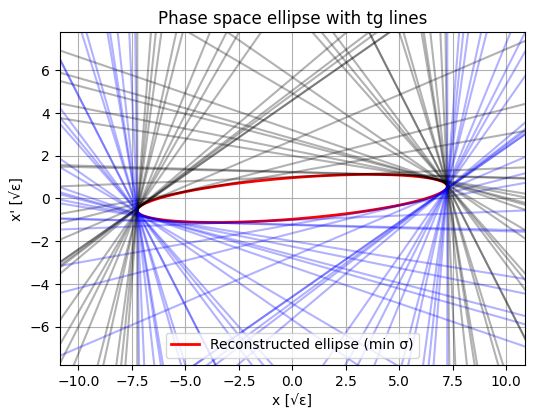

In [69]:
# Find the minimum sigma index (assumed waist)
idx_min = np.argmin(sigma_x)
_, _, _, beta0, alpha0, eps0 = phase_space_x[idx_min]

# Ellipse parameters
gamma0 = (1 + alpha0**2) / beta0

# Generate reference ellipse from β, α, ε at waist (normalized units)
theta = np.linspace(0, 2 * np.pi, 500)
x_ellipse = np.sqrt(eps0 * beta0) * np.cos(theta)
xp_ellipse = -np.sqrt(eps0 / beta0) * (alpha0 * np.cos(theta) + np.sin(theta))
ellipse = np.vstack([x_ellipse, xp_ellipse])

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(*ellipse, lw=2, color='red', label='Reconstructed ellipse (min σ)')

for (I, m, _, _, _, _), phi_deg in zip(phase_space_x, phi_x_deg):
    m = float(m)

    # Compute intercept b of the line tangent to the reference ellipse
    # Based on: b = sqrt(ε * (β m² + 2α m + γ))
    b_sq = eps0 * (beta0 * m**2 + 2 * alpha0 * m + gamma0)
    if b_sq < 0:
        continue  # skip unphysical
    b = np.sqrt(b_sq)

    # Plot both +b and -b tangents
    x_vals = np.linspace(-3 * np.sqrt(eps0 * beta0), 3 * np.sqrt(eps0 * beta0), 2)
    ax.plot(x_vals, m * x_vals + b, color='black', alpha=0.3)
    ax.plot(x_vals, m * x_vals - b, color='blue', alpha=0.3)

# Formatting
ax.set_xlabel("x [√ε]")
ax.set_xlim(-1.5 * np.sqrt(eps0 * beta0), 1.5 * np.sqrt(eps0 * beta0))
ax.set_ylim(-8 * np.sqrt(eps0 / beta0), 8 * np.sqrt(eps0 / beta0))
ax.set_ylabel("x' [√ε]")
ax.set_title("Phase space ellipse with tg lines")
ax.set_aspect('equal')
ax.grid(True)
ax.legend()
plt.show()


## Plotting (Quad Scans)

In [70]:
def plot_sigma_vs_pos(
    transport_tables, 
    quad_index=4, 
    quad_label="QDD515"
):
    """
    Plots σ_x and σ_y along s from a list of transport tables.

    Parameters:
    - transport_tables: list of (current, transport_table) tuples
    - quad_index: index of scanned quadrupole (used for title)
    - quad_label: label of the quadrupole for title and legend
    - unit_scale: scale to convert σ from m to mm (default: 1e3)
    """
    
    plt.figure(figsize=(10, 6))
    for current, T in transport_tables:
        plt.plot(T[:, 0], T[:, 1], label=rf'$\sigma_x$ (I={current:.1f} A)', linewidth=1.5)
    plt.xlabel('s [m]')
    plt.ylabel(r'$\sigma_x$ [mm]')
    plt.title(f'Quad {quad_index} scan ({quad_label}), $\sigma_x$')
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize=8, ncol=2)
    plt.tight_layout(rect=[0,0,0.8,1])
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    for current, T in transport_tables:
        plt.plot(T[:, 0], T[:, 2], '--', label=rf'$\sigma_y$ (I={current:.1f} A)', linewidth=1.5)
    plt.xlabel('s [m]')
    plt.ylabel(r'$\sigma_y$ [mm]')
    plt.title(f'Quad {quad_index} scan ({quad_label}), $\sigma_y$')
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize=8, ncol=2)
    plt.tight_layout(rect=[0,0,0.8,1])
    plt.grid(True)
    plt.show()


<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\s'
/var/folders/4v/0s5sj9mn17n0pz1bjkxr1kyc0000gn/T/ipykernel_76742/3066808183.py:21: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f'Quad {quad_index} scan ({quad_label}), $\sigma_x$')
/var/folders/4v/0s5sj9mn17n0pz1bjkxr1kyc0000gn/T/ipykernel_76742/3066808183.py:32: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f'Quad {quad_index} scan ({quad_label}), $\sigma_y$')


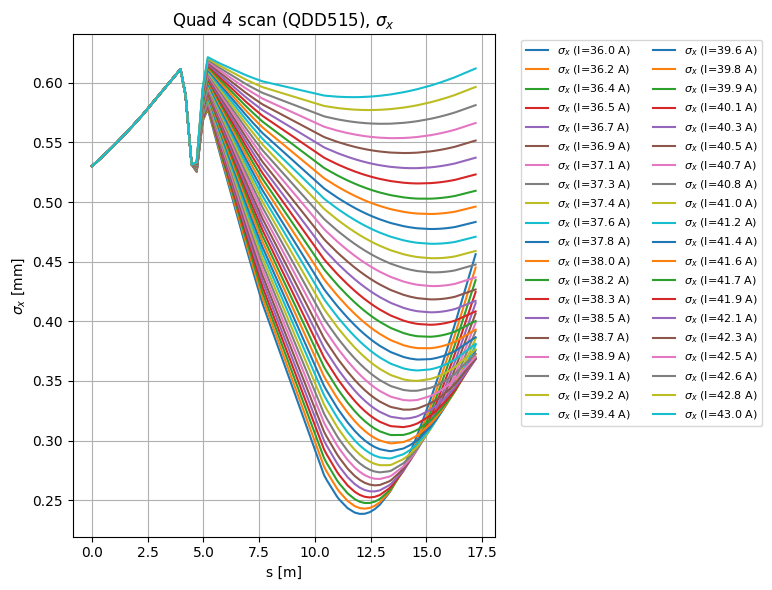

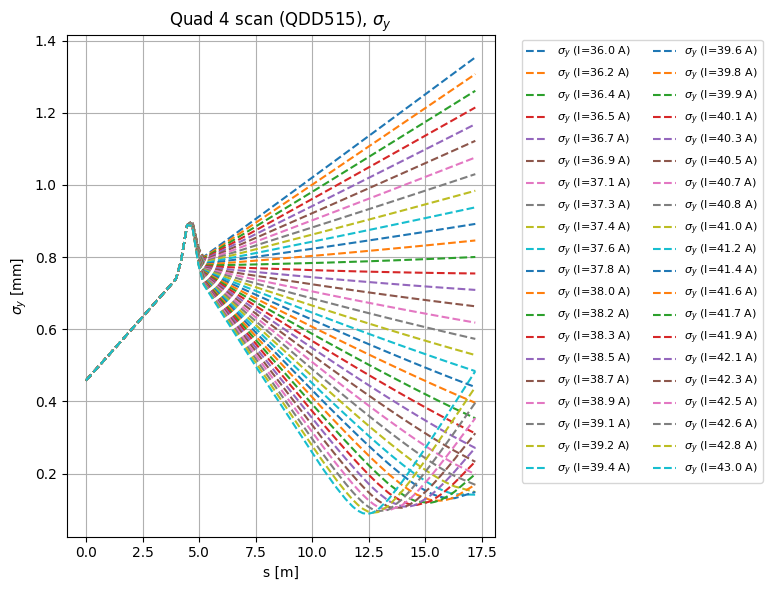

In [71]:
plot_sigma_vs_pos(transport_tables, quad_index=4, quad_label="QDD515")


In [72]:
def plot_sigma_vs_current(
    currents,
    sigma_x,
    sigma_y,
    quad_label="QDD515"
):
    """
    Plots sigma_x and sigma_y at the screen vs quadrupole current.

    Parameters:
    - currents: list of quadrupole current values [A]
    - sigma_x: list of σ_x values at the screen [m]
    - sigma_y: list of σ_y values at the screen [m]
    - quad_label: name of the scanned quadrupole for titles
    - unit_scale: scale to convert σ from m to mm (default: 1e3)
    """
    
    # Plot sigma_x
    plt.figure(figsize=(8, 5))
    plt.plot(currents, [s for s in sigma_x], 'o-', linewidth=2, label=r'$\sigma_x$')
    plt.xlabel('Quad current [A]')
    plt.ylabel(r'$\sigma_x$ at screen [mm]')
    plt.title(rf'$\sigma_x$ vs Current ({quad_label})')
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

    # Plot sigma_y
    plt.figure(figsize=(8, 5))
    plt.plot(currents, [s for s in sigma_y], 's--', linewidth=2, color='orange', label=r'$\sigma_y$')
    plt.xlabel('Quad current [A]')
    plt.ylabel(r'$\sigma_y$ at screen [mm]')
    plt.title(rf'$\sigma_y$ vs Current ({quad_label})')
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()


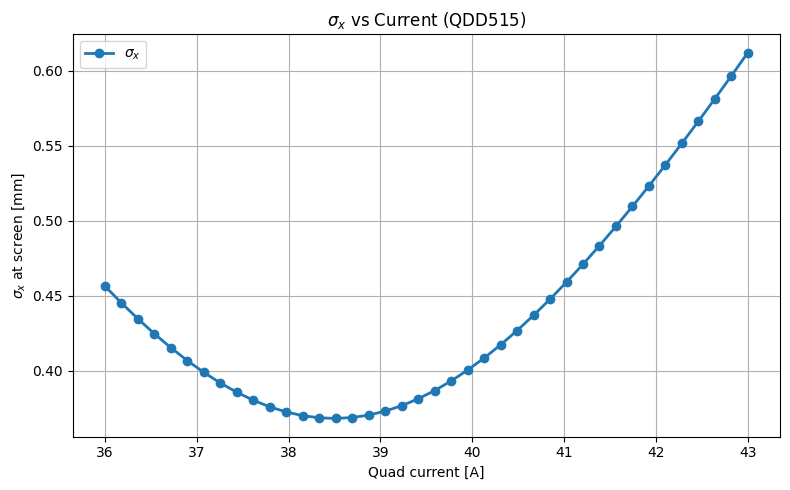

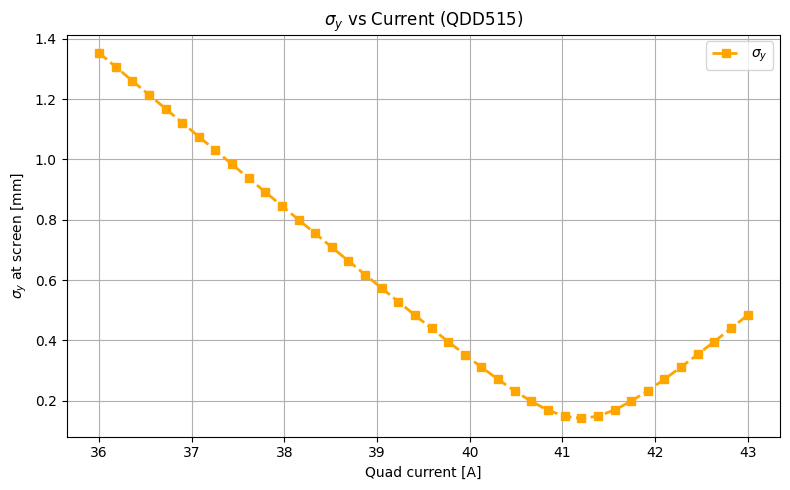

In [73]:
plot_sigma_vs_current(
    currents,
    sigma_x,
    sigma_y,
    quad_label="QDD515"
)


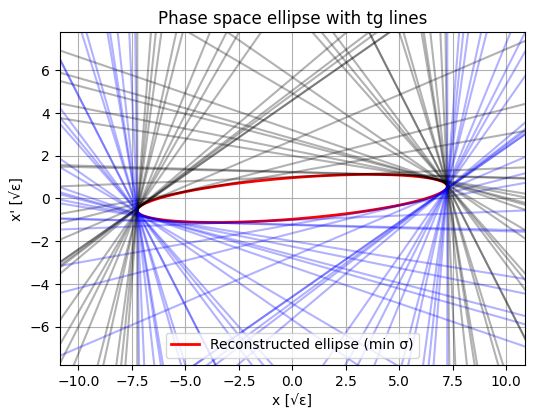

In [74]:
# Find the minimum sigma index (assumed waist)
idx_min = np.argmin(sigma_x)
_, _, _, beta0, alpha0, eps0 = phase_space_x[idx_min]

# Ellipse parameters
gamma0 = (1 + alpha0**2) / beta0

# Generate reference ellipse from β, α, ε at waist (normalized units)
theta = np.linspace(0, 2 * np.pi, 500)
x_ellipse = np.sqrt(eps0 * beta0) * np.cos(theta)
xp_ellipse = -np.sqrt(eps0 / beta0) * (alpha0 * np.cos(theta) + np.sin(theta))
ellipse = np.vstack([x_ellipse, xp_ellipse])

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(*ellipse, lw=2, color='red', label='Reconstructed ellipse (min σ)')

for (I, m, _, _, _, _), phi_deg in zip(phase_space_x, phi_x_deg):
    m = float(m)



    # Compute intercept b of the line tangent to the reference ellipse
    # Based on: b = sqrt(ε * (β m² + 2α m + γ))
    b_sq = eps0 * (beta0 * m**2 + 2 * alpha0 * m + gamma0)
    if b_sq < 0:
        continue  # skip unphysical
    b = np.sqrt(b_sq)

    # Plot both +b and -b tangents
    x_vals = np.linspace(-3 * np.sqrt(eps0 * beta0), 3 * np.sqrt(eps0 * beta0), 2)
    ax.plot(x_vals, m * x_vals + b, color='black', alpha=0.3)
    ax.plot(x_vals, m * x_vals - b, color='blue', alpha=0.3)

# Formatting
ax.set_xlabel("x [√ε]")
ax.set_xlim(-1.5 * np.sqrt(eps0 * beta0), 1.5 * np.sqrt(eps0 * beta0))
ax.set_ylim(-8 * np.sqrt(eps0 / beta0), 8 * np.sqrt(eps0 / beta0))
ax.set_ylabel("x' [√ε]")
ax.set_title("Phase space ellipse with tg lines")
ax.set_aspect('equal')
ax.grid(True)
ax.legend()
plt.show()


In [75]:
min_sigma_y = min(sigma_y)
min_index = sigma_y.index(min_sigma_y)
current_at_min_sigma_y = currents[min_index]
print("sigma_y min:", min_sigma_y)
print("Current at min sigma_y:", current_at_min_sigma_y)

sigma_y min: 0.14136260399644118
Current at min sigma_y: 41.205128205128204


In [76]:
min_sigma_x = min(sigma_x)
min_index = sigma_x.index(min_sigma_x)
current_at_min_sigma_x = currents[min_index]
print("sigma_x min:", min_sigma_x)
print("Current at min sigma_x:", current_at_min_sigma_x)

sigma_x min: 0.3680975229901062
Current at min sigma_x: 38.51282051282051


In [77]:
print(phase_space_x)

print(transport_tables)

[(np.float64(36.0), np.float64(-0.342445674496189), np.float64(0.05369777501823016), 11.457929942274994, -1.6312571674385767, 7.039999999999949), (np.float64(36.17948717948718), np.float64(-9.085082783156308), np.float64(-0.46432422326594064), 10.904167635942672, -1.5352379563067586, 7.039999999999993), (np.float64(36.35897435897436), np.float64(0.7608644059945747), np.float64(-0.06383468727821819), 10.3915104913576, -1.4424294952971795, 7.0399999999999086), (np.float64(36.53846153846154), np.float64(-0.28397726532220696), np.float64(0.05281028953985594), 9.91999077936482, -1.352834323032434, 7.039999999999966), (np.float64(36.717948717948715), np.float64(-1.966241557119379), np.float64(-0.11206453284997463), 9.489640783570243, -1.266454979142174, 7.039999999999972), (np.float64(36.8974358974359), np.float64(3.9112121915183917), np.float64(-0.2050874004369242), 9.100492800342789, -1.1832940042631623, 7.039999999999902), (np.float64(37.07692307692308), np.float64(0.8427447308702064), np

## Trying BO

In [78]:
from skopt import gp_minimize
from skopt import Optimizer
from skopt.utils import use_named_args
from skopt.utils import create_result
from skopt.space import Real
from skopt.plots import plot_convergence
import copy
from botorch.acquisition import UpperConfidenceBound
from botorch.models import SingleTaskGP


# from QuadBOFunc import quad_BO_objective

In [79]:
# OPTIMIZATION FUNCTION


history_x = []
history_sigma_x = []
history_sigma_y = []
history_all_currents = []

def quad_BO_objective(x, quad_indices, base_currents, B0, P_ref, get_Quad_K_from_I, get_lattice, get_Twiss):

    quad_currents = copy.deepcopy(base_currents)
    for idx, new_current in zip(quad_indices, x):
        quad_currents[idx] = new_current

    # Build and track lattice
    L = get_lattice('CA.QFD0350', 'CA.BTV0910', P_ref, quad_currents)
    L.get_length()
    B1 = L.track(B0)
    get_Twiss(B1)

    # Get beam sizes from transport table
    T = L.get_transport_table('%S %sigma_x %sigma_y')
    sigma_x = T[-1, 1]
    sigma_y = T[-1, 2]

    # Store values
    history_x.append(x[0])
    history_sigma_x.append(sigma_x)
    history_sigma_y.append(sigma_y)
    history_all_currents.append(quad_currents.copy())

    return (sigma_x - target_sigma_x)**2 + (sigma_y - target_sigma_y)**2  # Objective function to minimize (sum of squares of beam sizes)

# xopt




In [80]:
## WORK IN PROGRESS

# def quad_BO_objective(x, quad_indices, base_currents, B0, P_ref, get_Quad_K_from_I, get_lattice, get_Twiss):
quad_currents = copy.deepcopy(base_currents)
for idx, new_current in zip(quad_indices, x):
    quad_currents[idx] = new_current

# Build and track lattice
L = get_lattice('CA.QFD0350', 'CA.BTV0910', P_ref, quad_currents)
L.get_length()
B1 = L.track(B0)
get_Twiss(B1)

# Get beam sizes from transport table
T = L.get_transport_table('%S %sigma_x %sigma_y')
sigma_x = T[-1, 1]
sigma_y = T[-1, 2]

# Store values
history_x.append(x[0])
history_sigma_x.append(sigma_x)
history_sigma_y.append(sigma_y)
history_all_currents.append(quad_currents.copy())

# Compute main objective: match target sigmas
obj = (sigma_x - target_sigma_x)**2 + (sigma_y - target_sigma_y)**2

# Penalty for parabola shape: check 1:2 ratio using last few history values
penalty = 0
if len(history_sigma_x) >= 5:
    recent_x = np.array(history_x[-5:])
    recent_sigma_x = np.array(history_sigma_x[-5:])
    
    if np.all(np.isfinite(recent_sigma_x)):
        coeffs = np.polyfit(recent_x, recent_sigma_x**2, 2)
        a, b, c = coeffs

        if abs(a) > 1e-8 and np.all(np.isfinite(coeffs)):
            I0 = -b / (2*a)
            sigma_min_sq = np.polyval(coeffs, I0)
            sigma_arm_sq = np.polyval(coeffs, I0 + 1)
            desired_ratio_sq = (2 * np.sqrt(sigma_min_sq))**2

            if np.isfinite(sigma_arm_sq) and np.isfinite(desired_ratio_sq):
                penalty = (sigma_arm_sq - desired_ratio_sq)**2

    return obj + 0.01 * penalty  # adjust weight as needed


NameError: name 'base_currents' is not defined

In [ ]:
## WORK IN PROGRESS

# OPTIMIZATION SETUP

# Optimization parameters
target_sigma_x = 0.7
target_sigma_y = 0.7
sigma_tol = 0.05  # Threshold for both sigmas
max_iterations = 100

quad_indices = [3, 4, 5]  # Indices of quadrupoles to optimize
quad_label="Q*D500"
base_quad_currents = np.array([
    0,        # QFD350
    0,        # QDD355
    0,        # QFD360
    0,        # QFD510
    0,        # QDD515
    0,        # QFD520
    0,        # QFD760
    0,        # QDD765
    0,        # QFD770
    0,        # QDD870
    0         # QFD880
])  # Amps
search_space = [Real(16.0, 23.0, name='QFD510'), Real(36.0, 43.0, name='QDD515'), Real(16.0, 23.0, name='QFD520')]  # Create a search space for each quadrupole index

# Static arguments
args = (quad_indices, base_quad_currents, B0, P_ref, get_Quad_K_from_I, get_lattice, get_Twiss)
# args = (quad_indices, base_quad_currents, quad_names, camera, P_ref, twiss_init)

# Reset history before new optimization run
history_x = []
history_sigma_x = []
history_sigma_y = []
history_all_currents = []

opt = Optimizer(search_space, acq_func="EI", random_state=42)

for iteration in range(max_iterations):
    x = opt.ask()
    obj_value = quad_BO_objective(x, quad_indices, base_quad_currents, B0, P_ref, get_Quad_K_from_I, get_lattice, get_Twiss)
    opt.tell(x, obj_value)

    sigma_x = history_sigma_x[-1]
    sigma_y = history_sigma_y[-1]
    all_currents = history_all_currents[-1]

    print(f"Iter {iteration+1:02d} | Currents: {x} | σₓ: {sigma_x:.3f}, σᵧ: {sigma_y:.3f} | Obj: {obj_value:.4f}")
    

    # Recalculate Twiss from current best beam
    L_curr = get_lattice('CA.QFD0350', 'CA.BTV0910', P_ref, all_currents)
    L_curr.get_length()
    B_curr = L_curr.track(B0)
    twiss_curr = get_Twiss(B_curr)

    # Get Twiss at screen
    T_curr = L_curr.get_transport_table('%S %alpha_x %beta_x %emitt_x')
    alpha0, beta0, eps0 = T_curr[-1, 1:4]
    gamma0 = (1 + alpha0**2) / beta0

    # Compute R-matrix from B0 to B_curr
    R = R_matrix(B0, B_curr)

    # Compute phase advance and slope dynamically
    beta_ix, alpha_ix = B0.get_info().beta_x, B0.get_info().alpha_x
    beta_fx, alpha_fx = beta0, alpha0
    phi_x_rad, phi_x_deg = phase_advance(R, beta_ix, beta_fx, alpha_ix, alpha_fx)

    # Tangent slope (independent of scan history)
    m = -np.cos(phi_x_deg) / np.sin(phi_x_deg)


    # Generate ellipse
    theta = np.linspace(0, 2 * np.pi, 500)
    x_ellipse = np.sqrt(eps0 * beta0) * np.cos(theta)
    xp_ellipse = -np.sqrt(eps0 / beta0) * (alpha0 * np.cos(theta) + np.sin(theta))
    ellipse = np.vstack([x_ellipse, xp_ellipse])

    # Tangent slopes (use fixed ones from measurements)
    m_vals = [m for (_, m, *_), _ in zip(phase_space_x, phi_x_deg)]

    # Plot ellipse and tangent lines
    plt.figure(figsize=(6, 6))
    plt.plot(*ellipse, lw=2, color='red', label='Reconstructed ellipse')

    for m in m_vals:
        m = float(m)
        b_sq = eps0 * (beta0 * m**2 + 2 * alpha0 * m + gamma0)
        if b_sq < 0:
            continue
        b = np.sqrt(b_sq)
        x_vals = np.linspace(-3 * np.sqrt(eps0 * beta0), 3 * np.sqrt(eps0 * beta0), 2)
        plt.plot(x_vals, m * x_vals + b, color='black', alpha=0.3)
        plt.plot(x_vals, m * x_vals - b, color='blue', alpha=0.3)

    plt.xlabel("x [√ε]")
    plt.ylabel("x' [√ε]")
    plt.xlim(-1.5 * np.sqrt(eps0 * beta0), 1.5 * np.sqrt(eps0 * beta0))
    plt.ylim(-8 * np.sqrt(eps0 / beta0), 8 * np.sqrt(eps0 / beta0))
    plt.title(f"BO Iteration {iteration+1:02d}: Phase space ellipse")
    plt.grid(True)
    # plt.gca().set_aspect('equal')
    plt.legend()
    plt.pause(0.01)  # Show live
    plt.clf()        # Optional: clear figure to reuse


    if abs(sigma_x - target_sigma_x) < sigma_tol and abs(sigma_y - target_sigma_y) < sigma_tol:
        print("Threshold met! Optimization stop.")
        break
else:
    print("Reached max iterations.")


In [ ]:
# OPTIMIZATION SETUP

# Optimization parameters
target_sigma_x = 0.7
target_sigma_y = 0.7
sigma_tol = 0.05
max_iterations = 100

quad_indices = [3, 4, 5]  # Indices of quadrupoles to optimize
quad_label = "Q*D500"
base_quad_currents = np.array([
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
])  # Amps

search_space = [
    Real(16.0, 23.0, name='QFD510'),
    Real(36.0, 43.0, name='QDD515'),
    Real(16.0, 23.0, name='QFD520')
]

args = (quad_indices, base_quad_currents, B0, P_ref, get_Quad_K_from_I, get_lattice, get_Twiss)

# Reset history
history_x, history_sigma_x, history_sigma_y, history_all_currents = [], [], [], []

opt = Optimizer(search_space, acq_func="EI", random_state=42)

plt.ion()  # Enable interactive mode
fig, ax = plt.subplots(figsize=(6, 6)) # Create persistent plot

# Store for plotting
all_ellipses = []
all_tangents = []

for iteration in range(max_iterations):
    x = opt.ask()
    obj_value = quad_BO_objective(x, *args)
    opt.tell(x, obj_value)

    sigma_x = history_sigma_x[-1]
    sigma_y = history_sigma_y[-1]
    all_currents = history_all_currents[-1]

    print(f"Iter {iteration+1:02d} | Currents: {x} | σₓ: {sigma_x:.3f}, σᵧ: {sigma_y:.3f} | Obj: {obj_value:.4f}")

    # Get current optics and Twiss
    L_curr = get_lattice('CA.QFD0350', 'CA.BTV0910', P_ref, all_currents)
    B_curr = L_curr.track(B0)
    twiss_curr = get_Twiss(B_curr)
    T_curr = L_curr.get_transport_table('%S %alpha_x %beta_x %emitt_x')
    alpha0, beta0, eps0 = T_curr[-1, 1:4]
    gamma0 = (1 + alpha0**2) / beta0

    # Compute R-matrix and phase advance
    R = R_matrix(B0, B_curr)
    beta_ix, alpha_ix = B0.get_info().beta_x, B0.get_info().alpha_x
    phi_x_rad, _ = phase_advance(R, beta_ix, beta0, alpha_ix, alpha0)
    m = -np.cos(phi_x_rad) / np.sin(phi_x_rad)

    # Build and store ellipse
    theta = np.linspace(0, 2 * np.pi, 500)
    x_ellipse = np.sqrt(eps0 * beta0) * np.cos(theta)
    xp_ellipse = -np.sqrt(eps0 / beta0) * (alpha0 * np.cos(theta) + np.sin(theta))
    ellipse = np.vstack([x_ellipse, xp_ellipse])
    all_ellipses.append(ellipse)
    all_tangents.append((m, eps0, beta0, alpha0, gamma0))  # Store tangent params

    # Clear axes, not figure
    ax.clear()

    # Plot all ellipses and tangents so far
    for i, e in enumerate(all_ellipses):
        color = 'red' if i == iteration else 'gray'
        ax.plot(*e, lw=1.5 if i == iteration else 1, color=color, alpha=1.0 if i == iteration else 0.5)

    for m_i, eps_i, beta_i, alpha_i, gamma_i in all_tangents:
        x_vals = np.linspace(-3 * np.sqrt(eps_i * beta_i), 3 * np.sqrt(eps_i * beta_i), 2)
        b_sq = eps_i * (beta_i * m_i**2 + 2 * alpha_i * m_i + gamma_i)
        if b_sq > 0:
            b = np.sqrt(b_sq)
            ax.plot(x_vals, m_i * x_vals + b, color='blue', alpha=0.15)
            ax.plot(x_vals, m_i * x_vals - b, color='black', alpha=0.15)

    ax.set_xlabel("x [√ε]")
    ax.set_ylabel("x' [√ε]")
    ax.set_xlim(-3 * np.sqrt(eps0 * beta0), 3 * np.sqrt(eps0 * beta0))
    ax.set_ylim(-10 * np.sqrt(eps0 / beta0), 10 * np.sqrt(eps0 / beta0))
    ax.set_title(f"BO Iteration {iteration+1:02d}: Phase space buildup")
    ax.grid(True)
    plt.pause(0.05)

    plt.ioff()  # Turn off interactive mode
    plt.show()  # Show the final accumulated plot

    if abs(sigma_x - target_sigma_x) < sigma_tol and abs(sigma_y - target_sigma_y) < sigma_tol:
        print("Threshold met! Optimization stop.")
        break
else:
    print("Reached max iterations.")


In [ ]:
quad_names = [
    'QFD350', 'QDD355', 'QFD360',
    'QFD510', 'QDD515', 'QFD520',
    'QFD760', 'QDD765', 'QFD770',
    'QDD870', 'QFD880'
]

nonzero_history = []

for i, curr in enumerate(history_all_currents):
    nonzero = [(name, val) for name, val in zip(quad_names, curr) if val != 0]
    nonzero_history.append(nonzero)

# Print example: last iteration's non-zero values
print(f"Iteration {len(nonzero_history)} non-zero currents:")
for name, val in nonzero_history[-1]:
    print(f"{name}: {val:.1f} A")


In [ ]:
print(nonzero_history)

In [ ]:
# To sort the sigmas and currents for a parabola-like plot:

# Convert to numpy arrays if not already
history_x_arr = np.array(history_x)
history_sigma_x_arr = np.array(history_sigma_x)

# Get sorting indices for the current values
sort_idx = np.argsort(history_x_arr)
x_sorted = history_x_arr[sort_idx]
sigma_x_sorted = history_sigma_x_arr[sort_idx]
sigma_y_sorted = np.array(history_sigma_y)[sort_idx]


plt.figure(figsize=(10, 6))
plt.plot(x_sorted, sigma_x_sorted, 'o-', label=r'$\sigma_x$')
plt.plot(x_sorted, sigma_y_sorted, 's--', label=r'$\sigma_y$')
plt.xlabel('Quadrupole current [A]')
plt.ylabel('Beam size at screen [mm]')
plt.title(f'Quad {quad_label} Optimization Results')
plt.axhline(target_sigma_x, color='purple', linestyle='--', label=r'Target $\sigma$')
# plt.axhline(target_sigma_y, color='orange', linestyle='--', label=r'Target $\sigma_y$')
plt.legend()
plt.grid(True)

# Highlight the best (minimum sigma_x) point
best_x_idx = np.argmin(sigma_x_sorted)
best_y_idx = np.argmin(sigma_y_sorted)
plt.plot(x_sorted[best_x_idx], sigma_x_sorted[best_x_idx], 'ro', markersize=10, label='Best (min σₓ)')
plt.plot(x_sorted[best_y_idx], sigma_y_sorted[best_y_idx], 'yo', markersize=10, label='Best (min σᵧ)')  # Best σᵧ

# Highlight the last point (last in history)
plt.plot(history_x_arr[-1], history_sigma_x_arr[-1], 'gs', markersize=10, label='Last point')
plt.plot(history_x_arr[-1], history_sigma_y[-1], 'gs', markersize=10)  # Last σᵧ

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def get_sigmas(camera, s_x_meas, s_y_meas, current_setpoints, resolution_info):
    n = len(s_x_meas)
    if type(camera) in [str, np.str_]:
        # Group measurements with the same setpoints
        indecies = [(current_setpoints == current_setpoints[i]).all(axis=1) for i in range(n)]
    
        if resolution_info is None: 
             s_x_res = s_y_res = delta_s_x_res = delta_s_y_res = 0
        else:
            # If camera is a string, assume resolution info is a single list or array with four elements
            s_x_res, s_y_res, delta_s_x_res, delta_s_y_res = resolution_info
    else:
        # Also check that the measurement is made on the same screen
        indecies = [np.logical_and((current_setpoints == current_setpoints[i]).all(axis=1), camera == camera[i]) for i in range(n)]

        if resolution_info is None: 
             s_x_res = s_y_res = delta_s_x_res = delta_s_y_res = 0
        else:
            # If camera is a list or array of strings, assume resolution info is a dictionary with values that are lists or arrays with four elements
            s_x_res = np.array([resolution_info[camera[i]][0] for i in range(n)])
            s_y_res = np.array([resolution_info[camera[i]][1] for i in range(n)])
            delta_s_x_res = np.array([resolution_info[camera[i]][2] for i in range(n)])
            delta_s_y_res = np.array([resolution_info[camera[i]][3] for i in range(n)])

    # Adjust for resolution
    s_x = np.sqrt(s_x_meas**2 - s_x_res**2)
    s_y = np.sqrt(s_y_meas**2 - s_y_res**2)
    
    # Measurement uncertainty (one sigma)
    delta_s_x_meas = np.array([s_x_meas[index].std(ddof=1) for index in indecies])
    delta_s_y_meas = np.array([s_y_meas[index].std(ddof=1) for index in indecies])

    # Propagate uncertainty from resolution estimate
    delta_s_x = np.sqrt((s_x_meas * delta_s_x_meas / s_x)**2 + (s_x_res * delta_s_x_res / s_x)**2)
    delta_s_y = np.sqrt((s_y_meas * delta_s_y_meas / s_y)**2 + (s_y_res * delta_s_y_res / s_y)**2)

    return s_x, s_y, delta_s_x, delta_s_y


def lorentz_factor(P_ref):
    m_e = 0.51099895069 # MeV/c^2
    g = P_ref / m_e
    return g


def full_twiss(twiss_partial, twiss_cov):
    # Unpack twiss and calculate gamma
    emitt, beta, alpha = twiss_partial
    gamma = (1 + alpha**2) / beta

    # Standard deviations
    emitt_std, beta_std, alpha_std = np.sqrt(np.diag(twiss_cov))

    # Partial derivatives
    dgamma_dbeta = -(1 + alpha**2) / beta**2
    dgamma_dalpha = 2 * alpha / beta

    # Error propagation
    gamma_std = np.sqrt(dgamma_dbeta**2 * twiss_cov[1, 1] + 
                        2 * dgamma_dbeta * dgamma_dalpha * twiss_cov[1, 2] + 
                        dgamma_dalpha**2 * twiss_cov[2, 2])
    
    return np.array([emitt, beta, alpha, gamma]), np.array([emitt_std, beta_std, alpha_std, gamma_std])


In [ ]:
from scipy.optimize import curve_fit


def quad_scan_fit(camera, P_ref, s_x_meas, s_y_meas, current_setpoints, fit='chi_squared', reconstruction_point = 'CA.QFD0350', resolution_info=None):
    assert fit == 'chi_squared' or fit == 'least_squares',  "'fit' must be either 'chi_squared' or 'least_squares'"

    assert type(camera) in [str, np.str_, list, np.ndarray], "'screen' must be of type str, list or numpy.ndarray"
    if type(camera) in [str, np.str_]:
        assert len(s_x_meas) == len(s_y_meas) == len(current_setpoints), 'All inputs must be of the same length.'
        screen = camera.rstrip('LH')
    else:
        assert len(camera) == len(s_x_meas) == len(s_y_meas) == len(current_setpoints), 'All inputs must be of the same length.'
        screen = [camera.rstrip('LH') for i in range(len(camera))]

    n = len(s_x_meas)

    # Adjust for resolution limit
    s_x, s_y, delta_s_x, delta_s_y = get_sigmas(camera, s_x_meas, s_y_meas, current_setpoints, resolution_info)

    # For least squares, we assume the uncertainty delta is constant over all setpoints
    if fit == 'least_squares':
        delta_s_x = None
        delta_s_y = None
    
    lattices = []
    beta_x_matrix = np.empty((n, 3))
    beta_y_matrix = np.empty((n, 3))
    for i in range(n):
        quad_currents = current_setpoints[i]

        if type(screen) in [str, np.str_]:
            lattice = get_lattice(reconstruction_point, screen, P_ref, quad_currents)
        else:
            lattice = get_lattice(reconstruction_point, screen[i], P_ref, quad_currents)

        lattices.append(lattice)

        # Transfer matricies from twiss to beta for each current
        beta_x_matrix[i], beta_y_matrix[i] = np.array(lattice.get_twiss_matrix())[:, 0, :]

    g = lorentz_factor(P_ref)
    
    # Get the beam size squared
    sigma_sq = lambda beta_matrix, emitt, beta, alpha: emitt/g*beta_matrix@np.array([beta, alpha, (1+alpha**2)/beta])

    try:
        twiss_x_fit, twiss_x_cov, info_x = curve_fit(
            f=sigma_sq,
            xdata=beta_x_matrix, 
            ydata=s_x**2, 
            sigma=2*s_x*delta_s_x, 
            p0=(5, 10, 0), 
            absolute_sigma=False, # Increases the estimated variance by a factor chi2/dof, i.e. increases the variance for a bad fit
            full_output=True
        )[0:3]

        twiss_x, twiss_x_std = full_twiss(twiss_x_fit, twiss_x_cov)
        chi2_x = np.sum(info_x['fvec']**2)
    except RuntimeError:
        # Fit did not converge
        twiss_x = twiss_x_std = (np.nan, np.nan, np.nan, np.nan)
        chi2_x = np.nan
    
    try:
        twiss_y_fit, twiss_y_cov, info_y = curve_fit(
            f=sigma_sq,
            xdata=beta_y_matrix, 
            ydata=s_y**2, 
            sigma=2*s_y*delta_s_y, 
            p0=(5, 10, 0), 
            absolute_sigma=False, # Increases the estimated variance by a factor chi2/dof, i.e. increases the variance for a bad fit
            full_output=True
        )[0:3]

        twiss_y, twiss_y_std = full_twiss(twiss_y_fit, twiss_y_cov)
        chi2_y = np.sum(info_y['fvec']**2)
    except RuntimeError:
        # Fit did not converge
        twiss_y = twiss_y_std = (np.nan, np.nan, np.nan, np.nan)
        chi2_y = np.nan

    dof = n - 3
    chi2_reduced = (chi2_x/dof, chi2_y/dof)

    twiss = (*twiss_x, *twiss_y)
    twiss_std = (*twiss_x_std, *twiss_y_std)
    return twiss, twiss_std, chi2_reduced, lattices


In [ ]:
# # --- TWISS FIT FROM OPTIMIZED RESULTS ---
# history_x = np.array(history_x)
# history_sigma_x = np.array(history_sigma_x)
# history_sigma_y = np.array(history_sigma_y)
# history_all_currents = np.array(history_all_currents)


# twiss, twiss_std, chi2_reduced, fitted_lattices = quad_scan_fit(
#     camera='CA.BTV0910',
#     P_ref=P_ref,
#     s_x_meas=history_sigma_x,
#     s_y_meas=history_sigma_y,
#     current_setpoints=history_all_currents,
#     fit='chi_squared',
#     reconstruction_point='CA.QFD0350',  # or any element you wish to reconstruct at
#     resolution_info=None
# )

# # Unpack results
# emit_x, beta_x, alpha_x, gamma_x, emit_y, beta_y, alpha_y, gamma_y = twiss
# std_emit_x, std_beta_x, std_alpha_x, std_gamma_x, std_emit_y, std_beta_y, std_alpha_y, std_gamma_y = twiss_std
# chi2_x, chi2_y = chi2_reduced

# # --- PRINT RESULTS ---
# print(f"\nFitted Twiss parameters at reconstruction point:")
# print(f"  εₓ = {emit_x:.3e} ± {std_emit_x:.1e} mm·mrad")
# print(f"  βₓ = {beta_x:.3f} ± {std_beta_x:.2f} m")
# print(f"  αₓ = {alpha_x:.3f} ± {std_alpha_x:.2f}")
# print(f"  γₓ = {gamma_x:.3f} ± {std_gamma_x:.2f}")
# print(f"  εᵧ = {emit_y:.3e} ± {std_emit_y:.1e} mm·mrad")
# print(f"  βᵧ = {beta_y:.3f} ± {std_beta_y:.2f} m")
# print(f"  αᵧ = {alpha_y:.3f} ± {std_alpha_y:.2f}")
# print(f"  γᵧ = {gamma_y:.3f} ± {std_gamma_y:.2f}")
# print(f"  χ²/ndof (x, y) = ({chi2_x:.2f}, {chi2_y:.2f})")

# # (optional) You could also store `fitted_lattices` for further use.


In [ ]:
# Convergence Plotting

res = create_result(
    Xi=opt.Xi,
    yi=opt.yi,
    space=opt.space,
    rng=np.random.RandomState(42)
)


# Print best result
print("\nBest found solution:")
for idx, val in zip(quad_indices, res.x):
    print(f"  Quadrupole index {idx}: {val:.3f} A")
print(f"Objective value: {res.fun:.5e}")
print(f"  σₓ = {history_sigma_x[np.argmin(res.func_vals)]:.5e}")
print(f"  σᵧ = {history_sigma_y[np.argmin(res.func_vals)]:.5e}")

# Plot convergence
plot_convergence(res)
plt.title("Bayesian Optimization Convergence")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Plot beam sizes vs quadrupole current

print(f"\nFinal result at best current:")
print(f"  σₓ = {history_sigma_x[-1]:.5e}")
print(f"  σᵧ = {history_sigma_y[-1]:.5e}")
print(f"  Objective (σₓ + σᵧ)**2 = {res.fun:.5e}")

history_x = np.array(history_x)
history_sigma_x = np.array(history_sigma_x)
history_sigma_y = np.array(history_sigma_y)

# Get indices that would sort history_x
sorted_indices = np.argsort(history_x)

# Sort all arrays by history_x
x_sorted = history_x[sorted_indices]
sigma_x_sorted = history_sigma_x[sorted_indices]
sigma_y_sorted = history_sigma_y[sorted_indices]


# Now plot with lines connecting points in order
plt.figure(figsize=(10, 5))
plt.plot(x_sorted, sigma_x_sorted, 'o-', label='σₓ')
plt.plot(x_sorted, sigma_y_sorted, 's-', label='σᵧ')
plt.xlabel('Quadrupole current (A)')
plt.ylabel('Beam size (mm)')
plt.title(f'Beam Sizes vs Quadrupole {quad_label} Current')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
iterations = np.arange(len(history_x))

# Plot sigmas vs iteration
plt.figure(figsize=(10, 4))
plt.plot(iterations, history_sigma_x, 'o-', label='σₓ')
plt.plot(iterations, history_sigma_y, 's-', label='σᵧ')
plt.xlabel('Iteration')
plt.ylabel('Beam size (mm)')
plt.title(f'Beam Sizes over Optimization Iterations ({quad_label})')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot current vs iteration
plt.figure(figsize=(10, 4))
plt.plot(iterations, history_x, '^-', color='purple', label='Quadrupole Current (A)')
plt.xlabel('Iteration')
plt.ylabel('Current (A)')
plt.title(f'Quadrupole Current over Optimization Iterations ({quad_label})')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Trying RL

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# True beamline parameters (hidden from agent)
true_focus_strength = 1.5  # optimal quad strength [arb units]
beam_min_sigma = 0.3       # minimal beam size at optimal strength [mm]

# Beam size model: parabola with minimum at true_focus_strength
def simulate_beam_size(quad_strength):
    sigma = beam_min_sigma + 0.5 * (quad_strength - true_focus_strength)**2
    sigma += np.random.normal(0, 0.01)  # simulate noise
    return sigma

# Reward: minimize beam size -> negative sigma
def compute_reward(sigma):
    return -sigma

# Discretize quadrupole strengths
quad_strengths = np.linspace(0.5, 2.5, 21)  # 21 steps from 0.5 to 2.5
n_actions = len(quad_strengths)

# Q-table (stateless agent: only actions)
Q = np.zeros(n_actions)

# RL hyperparameters
alpha = 0.1    # learning rate
gamma = 0.9    # discount
epsilon = 0.2  # exploration probability
episodes = 100

reward_history = []

for ep in range(episodes):
    # ε-greedy action selection
    if np.random.rand() < epsilon:
        a = np.random.randint(n_actions)
    else:
        a = np.argmax(Q)
        
    quad_strength = quad_strengths[a]
    sigma = simulate_beam_size(quad_strength)
    reward = compute_reward(sigma)

    # Q-learning update
    Q[a] = Q[a] + alpha * (reward + gamma * np.max(Q) - Q[a])
    reward_history.append(reward)

# Plotting results
best_idx = np.argmax(Q)
print(f"Best quadrupole strength: {quad_strengths[best_idx]:.3f}")
print(f"Estimated minimum beam size: {-Q[best_idx]:.3f} mm")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(quad_strengths, Q, marker='o')
plt.axvline(x=quad_strengths[best_idx], color='r', linestyle='--', label='Best')
plt.xlabel("Quadrupole Strength")
plt.ylabel("Q-value")
plt.title("Learned Q-values")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward over Time")
plt.tight_layout()
plt.show()


## Simoultaneous scan of the whole triplet

In [ ]:
### QUAD SCANS ###

# Quad order is:
# [0] QFD350, [1] QDD355, [2] QFD360,
# [3] QFD510, [4] QDD515, [5] QFD520,
# [6] QFD760, [7] QDD765, [8] QFD770,
# [9] QDD870, [10] QFD880

import copy

# Define ranges
current_range_same = np.linspace(19.7, 21.7, 10)    # for QFD510 and QFD520
current_range_diff = np.linspace(40.0, 42.0, 10)    # for QDD515

quad_indices_same = [3, 5]  # Two quads with the same range
quad_index_diff = 4         # One quad with a different range

# Prepare outputs
transport_tables = []
currents_A = []
currents_B = []
currents_C = []
sigma_x_at_screen = []
sigma_y_at_screen = []

# Start nested loops
for current_same in current_range_same:
    for current_diff in current_range_diff:
        # Update currents
        for idx in quad_indices_same:
            quad_currents[idx] = current_same
        quad_currents[quad_index_diff] = current_diff

        # Recompute K1 values
        for j in range(len(quad_currents)):
            K1[j] = Q_polarity[j] * get_Quad_K_from_I(quad_currents[j], Lquad, P_ref)

        # Define all quadrupoles (same as before)
        QFD350 = RF_Track.Quadrupole(Lquad, P_ref/Q, K1[0])
        QDD355 = RF_Track.Quadrupole(Lquad, P_ref/Q, K1[1])
        QFD360 = RF_Track.Quadrupole(Lquad, P_ref/Q, K1[2])
        Triplett_300 = [QFD350, QDD355, QFD360]

        QFD510 = RF_Track.Quadrupole(Lquad, P_ref/Q, K1[3])
        QDD515 = RF_Track.Quadrupole(Lquad, P_ref/Q, K1[4])
        QFD520 = RF_Track.Quadrupole(Lquad, P_ref/Q, K1[5])
        Triplett_500 = [QFD510, QDD515, QFD520]

        QFD760 = RF_Track.Quadrupole(Lquad, P_ref/Q, K1[6])
        QDD765 = RF_Track.Quadrupole(Lquad, P_ref/Q, K1[7])
        QFD770 = RF_Track.Quadrupole(Lquad, P_ref/Q, K1[8])
        Triplett_700 = [QFD760, QDD765, QFD770]

        QDD870 = RF_Track.Quadrupole(Lquad, P_ref/Q, K1[9])
        QFD880 = RF_Track.Quadrupole(Lquad, P_ref/Q, K1[10])
        Doublet_800 = [QDD870, QFD880]

        # Track
        L = get_lattice(5, K1_override=K1)
        L.get_length()
        B1 = L.track(B0)
        get_Twiss(B1)

        # Transport table
        T = L.get_transport_table('%S %sigma_x %sigma_y')
        T_copy = copy.deepcopy(T)

        # Store
        transport_tables.append(((current_same, current_same, current_diff), T_copy))
        currents_A.append(current_same)
        currents_B.append(current_same)
        currents_C.append(current_diff)
        sigma_x_at_screen.append(T_copy[-1, 1])
        sigma_y_at_screen.append(T_copy[-1, 2])

### PLOTTING ###

from matplotlib import cm
from matplotlib.colors import Normalize

plt.figure(figsize=(8, 5))

# Normalize the colormap based on QFD520 (currents_C)
norm = Normalize(vmin=min(currents_C), vmax=max(currents_C))
cmap = cm.viridis

# Use color-coded scatter plot
sc = plt.scatter(currents_A, sigma_x_at_screen, c=currents_C, cmap=cmap, norm=norm)

# Proper colorbar from the scatter object
cbar = plt.colorbar(sc)
cbar.set_label('QDD515 current [A]')

plt.xlabel('QFD510/20 current [A]')
plt.ylabel(r'$\sigma_x$ at screen [mm]')
plt.title(r'$\sigma_x$ vs QFD510/20 (colored by QDD515)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Adding small misalignments, to check correctors' action and have some kind of Monte Carlo approach

In [ ]:
sigma_X = 0.100 # mm
sigma_ROLL = 0.100 # mrad

In [ ]:
nSeeds = 50

final_emitt_x = []
final_emitt_y = []


for i in range(nSeeds):
    print('Seed {}/{}'.format(i+1, nSeeds))  
    L.scatter_elements('quadrupole', sigma_X, sigma_X, 0, sigma_ROLL, 0, 0, 'center')
    B1 = L.track(B0)
    T = L.get_transport_table('%S %emitt_x %emitt_y')  
    plt.plot(T[:,0], T[:,1], 'C00', linewidth=2)
    plt.plot(T[:,0], T[:,2], 'C01', linewidth=2)

    final_emitt_x.append(T[-1,1])
    final_emitt_y.append(T[-1,2])
plt.legend([r'$\epsilon_x$', r'$\epsilon_y$'])
plt.xlabel('s [m]')
plt.ylabel(r'$\epsilon_n$ [mm.mrad]')


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(final_emitt_x, bins=10, color='C0', alpha=0.7)
plt.xlabel(r'Final $\epsilon_x$ [mm.mrad]')
plt.ylabel('Counts')
plt.title(r'$\epsilon_x$ distribution')
plt.subplot(1,2,2)
plt.hist(final_emitt_y, bins=10, color='C1', alpha=0.7)
plt.xlabel(r'Final $\epsilon_y$ [mm.mrad]')
plt.ylabel('Counts')
plt.title(r'$\epsilon_y$ distribution')
plt.tight_layout()
plt.show()

In [ ]:
nSeeds = 30

for i in range(nSeeds):
    print('Seed {}/{}'.format(i+1, nSeeds))  
    L.scatter_elements('quadrupole', sigma_X, sigma_X, 0, sigma_ROLL, 0, 0, 'center')
    B1 = L.track(B0)
    T = L.get_transport_table('%S %beta_x %beta_y')  
    plt.plot(T[:,0], T[:,1], 'C00', linewidth=2)
    plt.plot(T[:,0], T[:,2], 'C01', linewidth=2)
plt.legend([r'$\beta_x$', r'$\beta_y$'])
plt.xlabel('s [m]')
plt.ylabel(r'$\beta_n$ [m]')
plt.show()

In [ ]:
# RESPONSE MATRIX
R0 = L.get_response_matrix(B0)

print(R0)
x, y = R0.shape
print(f"R0 shape: {x} x {y}")

In [ ]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
x, y = R0.shape
x, y = np.meshgrid(np.arange(x), np.arange(y))
ax.plot_surface(x, y, R0, cmap='hot')
ax.set_xlabel('Correctors')
ax.set_ylabel('Bpms')

In [ ]:
# RESPONSE MATRIX
R0[1:5,1:5]

In [ ]:
plt.figure()
nSeeds = 30
L.align_elements() # zeros the offsets of all the elements
for i in range(nSeeds):
    print('Seed {}/{}'.format(i+1, nSeeds))
    L.scatter_elements('quadrupole', sigma_X, sigma_X, 0, sigma_ROLL, 0, 0, 'center')
    L.reset_correctors()
    L.orbit_correction(R0, B0, 0.01); 
    L.track(B0)
    T = L.get_transport_table('%S %emitt_x %emitt_y')  
    plt.plot(T[:,0], T[:,1], 'C00', linewidth=2)
    plt.plot(T[:,0], T[:,2], 'C01', linewidth=2)
plt.legend([r'$\epsilon_x$', r'$\epsilon_y$'])
plt.xlabel('s [m]')
plt.ylabel(r'$\epsilon_n$ [mm.mrad]')
plt.show()

In [ ]:
plt.figure()
nSeeds = 30
L.align_elements() # zeros the offsets of all the elements
for i in range(nSeeds):
    print('Seed {}/{}'.format(i+1, nSeeds))
    L.scatter_elements('quadrupole', sigma_X, sigma_X, 0, sigma_ROLL, 0, 0, 'center')
    L.reset_correctors()
    L.orbit_correction(R0, B0, 0.01); 
    L.track(B0)
    T = L.get_transport_table('%S %beta_x %beta_y')  
    plt.plot(T[:,0], T[:,1], 'C00', linewidth=2)
    plt.plot(T[:,0], T[:,2], 'C01', linewidth=2)
plt.legend([r'$\beta_x$', r'$\beta_y$'])
plt.xlabel('s [m]')
plt.ylabel(r'$\beta_n$ [m]')
plt.show()

In [ ]:
L.get_correctors_strengths()

In [ ]:
T = L.get_transport_table('%S %beta_x %beta_y')
print(T[:,2])